In [1]:
import datetime
import gripql
import pandas

In [2]:
conn = gripql.Connection("http://192.168.1.147:8201")

In [3]:
G  = conn.graph("covid")

In [4]:
G.query().V().hasLabel("SummaryLocation").has(gripql.contains("zipcodes", "97229")).execute()

[INFO]	2020-04-16 21:37:49,336	2 results received in 0 seconds


[<AttrDict({'gid': '41051', 'label': 'SummaryLocation', 'data': {'county': 'Multnomah County', 'projects': [], 'province_state': 'OR', 'submitter_id': '41051', 'type': 'summary_location', 'zipcodes': ['97292', '97205', '97292', '97206', '97292', '97216', '97292', '97223', '97292', '97266', '97292', '97239', '97292', '97227', '97292', '97203', '97292', '97208', '97292', '97282', '97292', '97133', '97292', '97010', '97292', '97233', '97292', '97220', '97292', '97236', '97292', '97034', '97292', '97210', '97292', '97212', '97292', '97214', '97292', '97218', '97292', '97290', '97292', '97294', '97292', '97254', '97292', '97293', '97292', '97009', '97292', '97296', '97292', '97250', '97292', '97232', '97292', '97231', '97292', '97221', '97292', '97258', '97292', '97030', '97292', '97019', '97292', '97211', '97292', '97213', '97292', '97215', '97292', '97014', '97292', '97283', '97292', '97240', '97292', '97251', '97292', '97080', '97292', '97060', '97292', '97204', '97292', '97222', '97292'

In [5]:
q = G.query().V("41067").out("summary_reports").render(["date", "confirmed", "deaths", "recovered"])

data = {}
for row in q:
    d = datetime.datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
    data[d] = {"confirmed":int(row[1]), "deaths" : int(row[2]), "recovered":int(row[3])}

[INFO]	2020-04-16 21:37:49,367	23 results received in 0 seconds


In [6]:
df = pandas.DataFrame(data).transpose().sort_index()

In [7]:
delta = pandas.Series( (df.index - df.index[0]).round("D").astype('timedelta64[D]'), index=df.index, name="days")

In [8]:
ddf = df.join(delta)

In [9]:
ddf

,confirmed,deaths,recovered,days
2020-03-23 23:19:34,69,1,0,0
2020-03-24 23:37:31,76,2,0,1
2020-03-25 23:33:19,96,2,0,2
2020-03-26 23:48:35,104,3,0,3
2020-03-27 22:14:55,122,3,0,4
2020-03-28 23:05:00,140,3,0,5
2020-03-29 23:08:00,154,3,0,6
2020-03-30 22:52:00,168,3,0,7
2020-03-31 23:43:56,186,3,0,8
2020-04-01 21:58:49,189,3,0,9


In [10]:
q = G.query().V("41067").out("census").has(gripql.eq("gender", None)).render(["population"])
population = sum(list(a[0] for a in q))

[INFO]	2020-04-16 21:37:49,480	25 results received in 0 seconds


In [11]:
G.listLabels()

{'vertex_labels': ['CensusReport', 'SummaryLocation', 'SummaryReport'],
 'edge_labels': ['census', 'census_of', 'performed_at', 'summary_reports']}

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

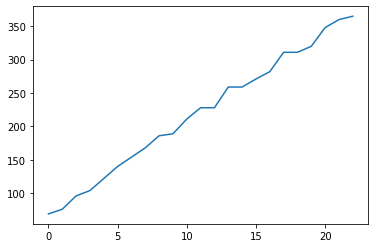

In [13]:
plt.plot(ddf['days'], df['confirmed'])

In [14]:
# Based on model found at https://github.com/omerka-weizmann/2_day_workweek/blob/master/code.ipynb
def SEIR_model(y,t,config):
    """
    SEIR model
    @y,t: - variables for the differential equations
    @config: include - rates beta,gamma for differential equations
    @rfunuc: a function that maps time to viral reproduction rate
    """
    S,E,I,R = y
    Tinc,Tinf = config["Tinc"],config["Tinf"]
    Rt = config["Rt"]
    dydt = [-Rt/Tinf * (I*S),
            Rt/Tinf * (I*S) - (1/Tinc)*E,
            (1/Tinc)*E - (1/Tinf)*I,
            (1/Tinf)*I]
    return dydt

In [15]:
Tinc = 3
Tinf = 15
startI = 0.00005

tmax = ddf['days'].max()+1
t = np.linspace(1,tmax,tmax)
config = {'Rt' : 3.0, 'Tinc': Tinc, 'Tinf': Tinf, 'beta': 0.25, 'gamma': 0.25}
SEIR_y0 = [1-startI,startI/2,startI/2,0]

modelOutput = odeint(SEIR_model, SEIR_y0, t, args=(config,), atol=1e-12, rtol=1e-12)
    

In [16]:
modelSums = pandas.DataFrame(modelOutput[:,[1,2,3]]).sum(axis=1)

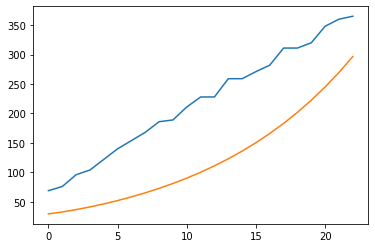

In [17]:
plt.plot(ddf['days'], ddf['confirmed'])
plt.plot(ddf['days'], modelSums[ddf['days']] * population )

In [18]:
ddf['confirmed'].values - (modelSums[ddf['days']] * population)

0      39.492450
1      43.174918
2      59.201916
3      62.643499
4      75.525109
5      87.843219
6      95.574759
7     102.682710
8     113.119345
9     107.828010
10    120.743982
11    127.794759
12    116.899964
13    135.970989
14    122.910462
15    120.611563
16    115.957224
17    127.819216
18    109.057130
19     97.517248
20    103.031304
21     90.415121
22     68.467114
dtype: float64

In [87]:
def calc_delta(df, R=3.0, Tinc=3, Tinf=15, startI=0.00005, beta=0.25, gamma=0.25, Toffset=0):
    tmax = df['days'].max()+1+Toffset
    t = np.linspace(1,tmax,tmax)
    config = {'Rt' : R, 'Tinc': Tinc, 'Tinf': Tinf, 'beta': 0.25, 'gamma': 0.25}
    SEIR_y0 = [1-startI,startI/2,startI/2,0]
    
    print(config)

    modelOutput = odeint(SEIR_model, SEIR_y0, t, args=(config,), atol=1e-12, rtol=1e-12)
    # exposed + infected + recovered 
    modelSums = pandas.DataFrame(modelOutput[:,[1,2,3]]).sum(axis=1)
    # compare to confirmed numbers
    delta = np.sum(np.power(df['confirmed'].values - (modelSums[df['days']+Toffset] * population),2))
    print(delta)
    return delta

In [89]:
calc_delta(ddf, R=2.6, Toffset=5)


{'Rt': 2.6, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
112200.77776798235


112200.77776798235

In [90]:
out = minimize(lambda x: calc_delta(ddf, R=x[0], Toffset=5), (3), bounds=((1,5),), method="L-BFGS-B", options={"ftol":1e-12})

{'Rt': 3.0, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
55755.57898798663
{'Rt': 3.00000001, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
55755.58004834627
{'Rt': 1.0, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
780066.0980877717
{'Rt': 1.00000001, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
780066.0948056707
{'Rt': 2.8856461263772695, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
53461.390149150895
{'Rt': 2.8856461363772694, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
53461.38955868635
{'Rt': 2.9265480638899053, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
52141.052988511125
{'Rt': 2.9265480738899052, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
52141.05294161367
{'Rt': 2.930076969095161, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
52133.18470333635
{'Rt': 2.930076979095161, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}
52133.18470569595
{'Rt': 2.92990792110805, 'Tinc': 3, 'Tinf': 15, 'beta': 0.25, 'gamma': 0.25}

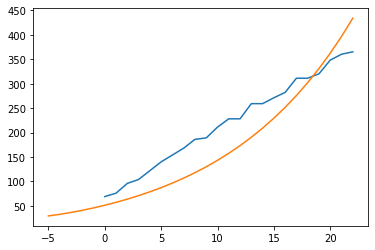

In [115]:
Tinc = 3
Tinf = 15
startI = 0.00005
Rt = 2.9
Toffset = 5
tmax = ddf['days'].max()+1+Toffset
t = np.linspace(1,tmax,tmax)
config = {'Rt' : Rt, 'Tinc': Tinc, 'Tinf': Tinf, 'beta': 0.25, 'gamma': 0.25}
SEIR_y0 = [1-startI,startI/2,startI/2,0]


modelOutput = odeint(SEIR_model, SEIR_y0, t, args=(config,), atol=1e-12, rtol=1e-12)
modelSums = pandas.DataFrame(modelOutput[:,[1,2,3]]).sum(axis=1)

plt.plot(ddf['days'], ddf['confirmed'])
plt.plot(t-1-Toffset, modelSums[t-1] * population )

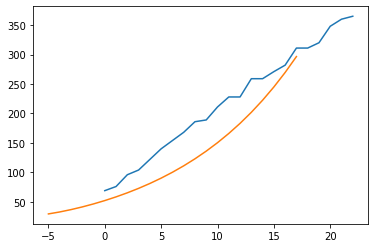

In [94]:
plt.plot(ddf['days'], ddf['confirmed'])
plt.plot(ddf['days'] - 5, modelSums[ddf['days']] * population )